In [1]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%load_ext autotime

time: 139 µs (started: 2022-08-01 10:21:20 +00:00)


In [3]:
from math import sqrt, floor
import numpy as np

def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

time: 75.3 ms (started: 2022-08-01 10:21:23 +00:00)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

time: 1.46 s (started: 2022-08-01 10:21:26 +00:00)


In [5]:
df = pd.read_csv("https://github.com/sumit07041997/Thesis/blob/2d50e96fbfd37f3515a6be03bd548c38a72cb88f/salary%5B1%5D.csv?raw=true")
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


time: 1.88 s (started: 2022-08-01 10:21:33 +00:00)


In [6]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

time: 5.47 ms (started: 2022-08-01 10:21:38 +00:00)


In [7]:
data = df.drop(['fnlwgt','education','occupation','capital-gain','capital-loss','native-country'],axis=1)
data

,age,workclass,education-num,marital-status,relationship,race,sex,hours-per-week,salary
0,39,State-gov,13,Never-married,Not-in-family,White,Male,40,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Husband,White,Male,13,<=50K
2,38,Private,9,Divorced,Not-in-family,White,Male,40,<=50K
3,53,Private,7,Married-civ-spouse,Husband,Black,Male,40,<=50K
4,28,Private,13,Married-civ-spouse,Wife,Black,Female,40,<=50K
...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Wife,White,Female,38,<=50K
32557,40,Private,9,Married-civ-spouse,Husband,White,Male,40,>50K
32558,58,Private,9,Widowed,Unmarried,White,Female,40,<=50K
32559,22,Private,9,Never-married,Own-child,White,Male,20,<=50K


time: 25.2 ms (started: 2022-08-01 10:21:40 +00:00)


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(data[['workclass','marital-status','relationship','race','sex']]).toarray())
data = data.join(enc_df)
data

,age,workclass,education-num,marital-status,relationship,race,sex,hours-per-week,salary,0,...,19,20,21,22,23,24,25,26,27,28
0,39,State-gov,13,Never-married,Not-in-family,White,Male,40,<=50K,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Husband,White,Male,13,<=50K,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,38,Private,9,Divorced,Not-in-family,White,Male,40,<=50K,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,53,Private,7,Married-civ-spouse,Husband,Black,Male,40,<=50K,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,28,Private,13,Married-civ-spouse,Wife,Black,Female,40,<=50K,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Wife,White,Female,38,<=50K,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
32557,40,Private,9,Married-civ-spouse,Husband,White,Male,40,>50K,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
32558,58,Private,9,Widowed,Unmarried,White,Female,40,<=50K,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
32559,22,Private,9,Never-married,Own-child,White,Male,20,<=50K,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


time: 108 ms (started: 2022-08-01 10:21:47 +00:00)


In [9]:
lable = data['salary'].copy()
data = data.drop(['workclass','marital-status','relationship','race','sex','salary'],axis=1)
lable.value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

time: 20.5 ms (started: 2022-08-01 10:21:49 +00:00)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data= scaler.fit_transform(data)

array([[ 0.03067056,  1.13473876, -0.03542945, ...,  0.4130197 ,
        -0.70307135,  0.70307135],
       [ 0.83710898,  1.13473876, -2.22215312, ...,  0.4130197 ,
        -0.70307135,  0.70307135],
       [-0.04264203, -0.42005962, -0.03542945, ...,  0.4130197 ,
        -0.70307135,  0.70307135],
       ...,
       [ 1.42360965, -0.42005962, -0.03542945, ...,  0.4130197 ,
         1.42233076, -1.42233076],
       [-1.21564337, -0.42005962, -1.65522476, ...,  0.4130197 ,
        -0.70307135,  0.70307135],
       [ 0.98373415, -0.42005962, -0.03542945, ...,  0.4130197 ,
         1.42233076, -1.42233076]])

time: 27.6 ms (started: 2022-07-29 18:29:32 +00:00)


/usr/local/lib/python3.7/dist-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.7/dist-packages/yellowbrick/cluster/elbow.py:361: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


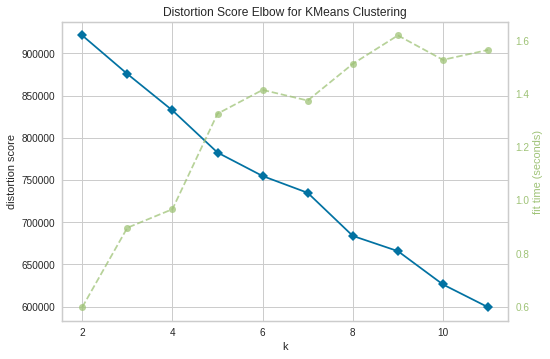

time: 13.6 s (started: 2022-07-29 18:30:07 +00:00)


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion'
)
visualizer.fit(data)        
visualizer.show() 

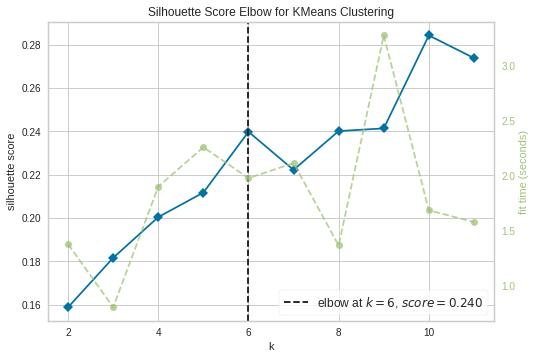

time: 2min 31s (started: 2022-07-29 18:31:10 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette')
visualizer.fit(data) 
visualizer.show()

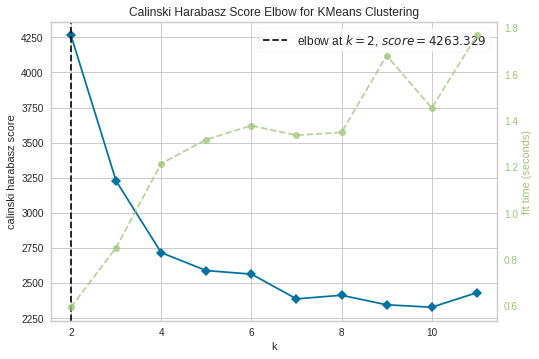

time: 13.5 s (started: 2022-07-29 18:33:51 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(data) 
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=2,init='random', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  13
time: 332 ms (started: 2022-07-29 18:34:12 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  6
time: 710 ms (started: 2022-07-29 18:34:16 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=3,init=naive_sharding(data,3), random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  12
time: 366 ms (started: 2022-07-29 18:34:29 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


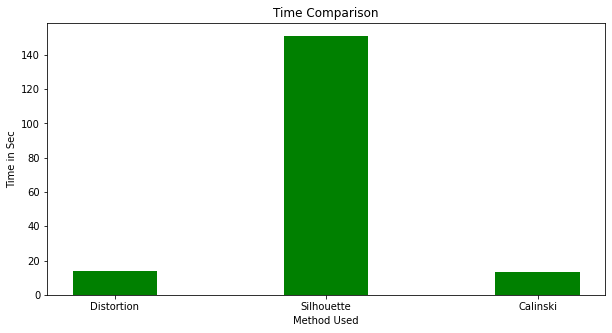

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

method = ['Distortion','Silhouette','Calinski']
time = [13.6,151,13.5]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, time, color ='green',
        width = 0.4)
 
plt.xlabel("Method Used")
plt.ylabel("Time in Sec")
plt.title("Time Comparison")
plt.show()